### Calculate weighted means in transformed space
- to allow weighting for averages in transformed space, we need to also transform the weights
- that means transforming dz when transforming in z, and transforming areacello when transforming in latitude
- when transforming in z, we do not need to *also* transform dx, simply because we are taking an average along each line of latitude, in which all dx's are the same (we *could* transform dz * dx, but the result would be the same).
- **conservative transformation** means that the operation will retain the total integrated value of a quantity along the transformed dimension. This is important for *extensive* quantities such as distances/metrics. It means that if I transform dz *conservatively* into temperature space, the sum of dz (at each point in x and y) in temperature space will be the same of the sum through depth space (i.e. prior to transformation). Thus, I am not losing any water. So *conservative transformations* are required for calculations in which we need to keep track of metrics, e.g. for a weighted mean.
- Performing conservative transformation requires more information on the orientation of the grid. In particular, it needs to know the locations and data at the "outside" of the grid cells. Below, I have included code to calculate a more complete xgcm Grid object, with all of the necessary information in the x, y, and z dimensions.

In [195]:
import intake
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram

import gsw

from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import combine_datasets, merge_variables, match_metrics
from dask.diagnostics import ProgressBar

In [139]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

In [183]:
variables = ['fgco2','thetao','talk']
# intake options
kwargs = dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
              preprocess=combined_preprocessing, aggregate=False)
z_kwargs = {'consolidated': True, 'use_cftime': True}
# model details
model_kwargs = dict(experiment_id=['historical'],
                    member_id = ['r1i1p1f1'],
                    grid_label=['gr'],
                    source_id=['CESM2-FV2'])
# query
query = dict(table_id=['Omon'],
             variable_id=variables,
             **model_kwargs)
cat = col.search(**query)
dd_vars = cat.to_dataset_dict(**kwargs)

dd_vars = merge_variables(dd_vars)

# Get areacello
# (note that we could also query areacello,
# but match_metrics is a useful approach when
# working with different models)
query = dict(table_id=['Ofx'],
             variable_id=['areacello'],
             **model_kwargs)
cat_metric = col.search(**query)
dd_metric = cat_metric.to_dataset_dict(**kwargs)

dddone = match_metrics(dd_vars, dd_metric, ['areacello'])

ds = dddone['CESM2-FV2.gr.historical.Omon.r1i1p1f1'].sel(y = slice(-90,-30)).isel(time=0)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


<xarray.Dataset>
Dimensions:        (y: 60, x: 360, bnds: 2, vertex: 4, lev: 33)
Coordinates: (12/15)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(60, 2, 360), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 60), meta=np.ndarray>
    time           object 1850-01-15 13:00:00
    time_bounds    (bnds) object dask.array<chunksize=(2,), meta=np.ndarray>
    ...             ...
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
    areacello      (y, x) float64 dask.array<chunksize=(60, 360), meta=np.ndarray>
Data variables:
    fgco2          (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    thetao         (lev, y, x) float32 dask.array<chunksize=(33, 60, 360), meta=np.ndarray>
    talk           (lev, y, x) float32 dask.array<chunksize=(33, 60, 360), meta=np.ndarray>
Attributes: (12/42)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1559
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r1i1p1f1
    version_id:             v20191120
    intake_esm_varname:     None

In [184]:
# Get some more grid information
# (and correct the lev variable
# so that it is actually between
# lev_bounds)

# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

def get_xgcm(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    xgrid = Grid(ds, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'left':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

def get_xgcm_special(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations
        This is a hacked version to specify "outer" coordinates for y,
        for use with transform method.'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    lat_left = np.append(ds[gridlat+'_left'],ds[gridlat+'_left'].isel(y_left=-1)+1)
    ds = ds.assign_coords({gridlat+'_left':lat_left})
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'}
    }
    xgrid = Grid(ds, coords=coords, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'outer':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['talk'])

In [181]:
ds

<xarray.Dataset>
Dimensions:        (y: 60, x: 360, bnds: 2, vertex: 4, lev: 33, lev_outer: 34,
                    x_left: 360, y_left: 61)
Coordinates: (12/18)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(60, 2, 360), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 60), meta=np.ndarray>
    time           object 1850-01-15 13:00:00
    time_bounds    (bnds) object dask.array<chunksize=(2,), meta=np.ndarray>
    ...             ...
  * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 4.5e+03 5e+03 5.375e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
    areacello      (y, x) float64 dask.array<chunksize=(60, 360), meta=np.ndarray>
  * lev_outer      (lev_outer) float64 0.0 5.0 15.0 ... 5.25e+03 5.5e+03
  * x_left         (x_left) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * y_left         (y_left) float64 -90.0 -89.0 -88.0 ... -32.0 -31.0 -30.0
Data variables:
    fgco2          (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    thetao         (lev, y, x) float32 dask.array<chunksize=(33, 60, 360), meta=np.ndarray>
    talk           (lev, y, x) float32 dask.array<chunksize=(33, 60, 360), meta=np.ndarray>
    dxG            (x_left, y) float64 968.6 2.906e+03 ... 9.464e+04 9.564e+04
    dyG            (x, y_left) float64 nan 1.11e+05 1.11e+05 ... 1.11e+05 nan
    dxC            (x, y) float64 968.6 2.906e+03 ... 9.464e+04 9.564e+04
    dyC            (x, y) float64 -1.11e+05 -1.11e+05 ... -1.11e+05 -1.11e+05
    dz             (lev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    dz3d           (lev, y, x) float64 dask.array<chunksize=(33, 60, 360), meta=np.ndarray>
Attributes: (12/42)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1559
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r1i1p1f1
    version_id:             v20191120
    intake_esm_varname:     None

### Vertical transformation
Keeping track of metrics

In [142]:
# Following conservative transformation tutorial
# https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-transformation
# https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-Interpolation

# Note on weights:
# Because dx are all the same at each latitude, and I am taking an average along
# each latitude, I do not have to weight by dx. However, because each thetao bin
# will have a different thickness at each longitude, I do need to weight by the 
# thickness.

target = np.linspace(-2, 30, 60)

# Interpolate thetao onto lev_outer
ds['thetao_outer'] = xgrid.interp(ds['thetao'], 'Z', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})
# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'])
# Transform var*dz
ds_t['talk-dz'] = xgrid.transform(ds['talk']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'])

# Now get dz-weighted mean in x
ds_t['talk'] = ds_t['talk-dz'].sum('x')/ds_t['dz3d'].sum('x')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


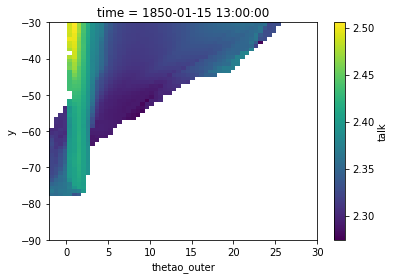

In [143]:
ds_t['talk'].plot()

### Latitudinal transformation
Keeping track of metrics

In [192]:
# Following conservative transformation tutorial
# https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-transformation
# https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-Interpolation
# Hacking to transform in Y, rather than Z

# Note on weights:
# Here, the average is going to be taken over x and y, meaning that I need to
# for spacing differences in both of those dimensions, i.e. I need to weight by
# the area of each grid cell.

target = np.linspace(-2, 30, 60)

# Interpolate thetao onto y_left
ds['thetao_outer'] = xgrid.interp(ds['thetao'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'y_left':-1})
# Transform areacello
ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


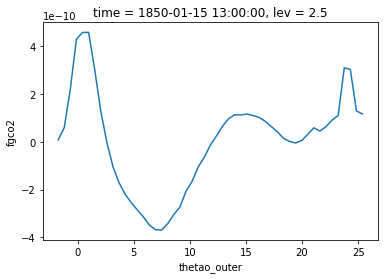

In [194]:
ds_t['fgco2'].plot()